In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob

pd.set_option("display.max_columns", 500)
plt.style.use('seaborn-v0_8-colorblind')
pal = sns.color_palette()

# Read in and Format the data

In [2]:
column_subset = [
    "FlightDate",
    "Airline",
    "Flight_Number_Marketing_Airline",
    "Origin",
    "Dest",
    "Cancelled",
    "Diverted",
    "CRSDepTime",
    "DepTime",
    "DepDelayMinutes",
    "OriginAirportID",
    "OriginCityName",
    "OriginStateName",
    "DestAirportID",
    "DestCityName",
    "DestStateName",
    "TaxiOut",
    "TaxiIn",
    "CRSArrTime",
    "ArrTime",
    "ArrDelayMinutes",
]

parquet_file = glob('/kaggle/input/flight-delay-dataset-20182022/*parquet')

dfs = []
for f in parquet_file:
    dfs.append(
        pd.read_parquet(f, columns=column_subset)
    )
    
df = pd.concat(dfs).reset_index(drop=True)


cat_cols = ['Airline', 'Origin', 'Dest', 'OriginStateName', 'DestStateName']
for c in cat_cols:
    df[c]=df[c].astype('category')

In [3]:
parquet_file

['/kaggle/input/flight-delay-dataset-20182022/Combined_Flights_2022.parquet',
 '/kaggle/input/flight-delay-dataset-20182022/Combined_Flights_2021.parquet',
 '/kaggle/input/flight-delay-dataset-20182022/Combined_Flights_2018.parquet',
 '/kaggle/input/flight-delay-dataset-20182022/Combined_Flights_2020.parquet',
 '/kaggle/input/flight-delay-dataset-20182022/Combined_Flights_2019.parquet']

# Understand the `DepDelayMinutes`

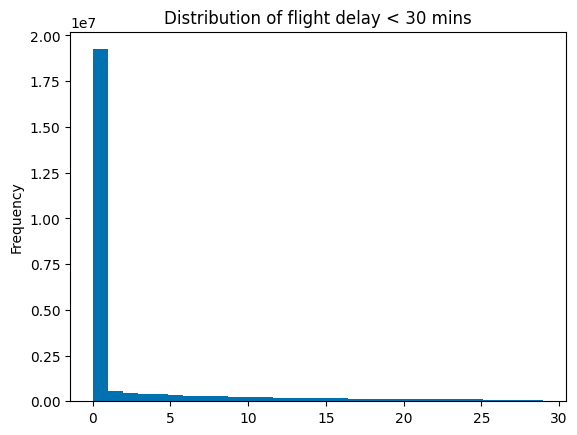

In [4]:
df.query('DepDelayMinutes < 30')['DepDelayMinutes'].plot(kind='hist', bins=30, title='Distribution of flight delay < 30 mins')
plt.show()

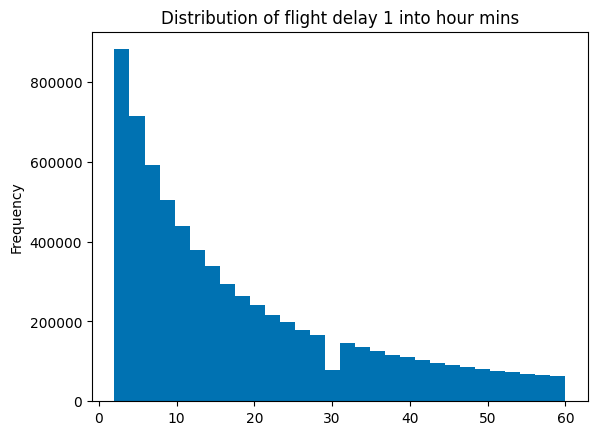

In [5]:
df.query('DepDelayMinutes > 1 and DepDelayMinutes < 61')['DepDelayMinutes'].plot(kind='hist', bins=30, title='Distribution of flight delay 1 into hour mins')
plt.show()

# Grouping of delays
Per Wikipedia https://en.wikipedia.org/wiki/Flight_cancellation_and_delay:

```
Delays are divided into three categories, namely "on time or small delay" (up to 15 minutes delay), "Medium delay" (15 – 45 minutes delay) and "Large delay" ( 45 minutes delay).
```

In [6]:
df['DelayGroup'] = None
df.loc[df['DepDelayMinutes']== 0, "DelayGroup"] = "OnTime/Early"
df.loc[(df['DepDelayMinutes'] > 0) & (df['DepDelayMinutes'] <= 15), "DelayGroup"] = "Small Delay"
df.loc[(df['DepDelayMinutes'] > 15) & (df['DepDelayMinutes'] <= 45), "DelayGroup"] = "Medium Delay"
df.loc[df['DepDelayMinutes'] > 45, "DelayGroup"] = "Large Delay"
df.loc[df['Cancelled'], 'DelayGroup'] = 'Cancelled'

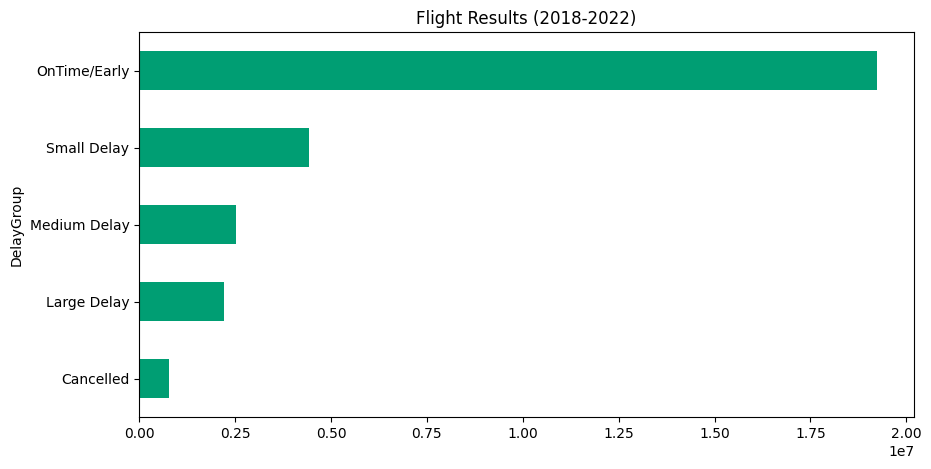

In [7]:
df['DelayGroup'].value_counts(ascending=True).plot(kind='barh', figsize=(10,5), color=pal[1], title='Flight Results (2018-2022)')
plt.show()

# How Many Flights Per Year?

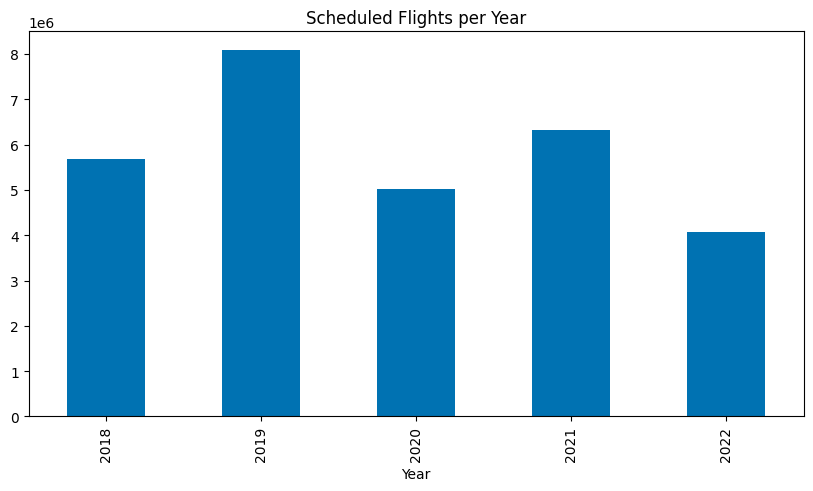

In [8]:
df['Year'] = df['FlightDate'].dt.year
df['Year'].value_counts().sort_index().plot(
    kind='bar', figsize=(10,5), title='Scheduled Flights per Year'
)
plt.show()

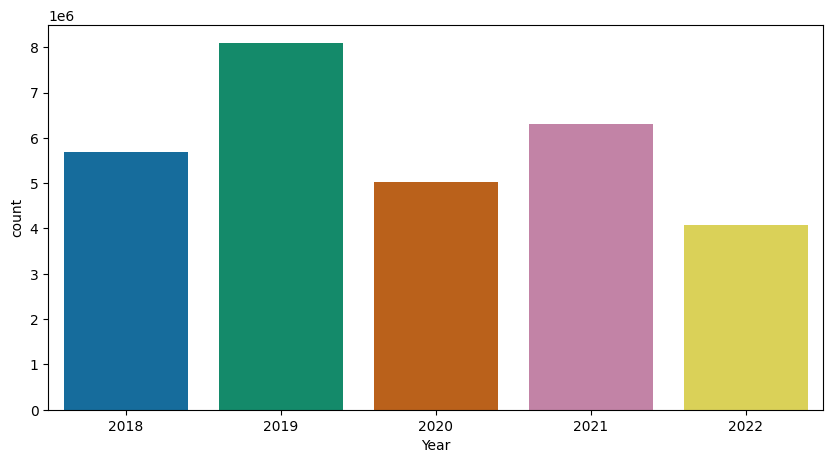

In [9]:
# or wen can user count plot from seaborn

plt.figure(figsize=(10,5))
sns.countplot(x=df['Year'])
plt.show()

# What is the % of Flight Results by Year

In [10]:
df_agg = df.groupby('Year')['DelayGroup'].value_counts(normalize=True).unstack()*100

In [11]:
col_order = ['OnTime/Early',  'Small Delay', 'Medium Delay', 'Large Delay', 'Cancelled']
df_agg[col_order].style.background_gradient(cmap='Greens')

DelayGroup,OnTime/Early,Small Delay,Medium Delay,Large Delay,Cancelled
Year,,,,,
2018,64.115615,16.474583,9.538448,8.317789,1.553565
2019,64.619787,15.716778,9.081583,8.683248,1.898604
2020,76.052291,9.653418,4.572319,3.727722,5.994249
2021,65.698142,16.145308,8.917879,7.479795,1.758876
2022,58.801153,17.706368,10.926539,9.545283,3.020657


# Results by Month

In [12]:
df['Month'] = df['FlightDate'].dt.month
df_agg = df.groupby('Month')['DelayGroup'].value_counts(normalize=True).unstack()*100

In [13]:
col_order = ['OnTime/Early',  'Small Delay', 'Medium Delay', 'Large Delay', 'Cancelled']
df_agg[col_order].style.background_gradient(cmap='Blues')

DelayGroup,OnTime/Early,Small Delay,Medium Delay,Large Delay,Cancelled
Month,,,,,
1,68.169907,13.961832,7.878093,7.008976,2.981192
2,64.960611,15.300969,8.828322,7.786858,3.123240
3,66.363322,14.172305,7.716007,6.173113,5.575252
4,64.436275,14.051844,7.824258,6.853866,6.833756
5,65.023841,16.224252,8.965554,7.875154,1.911198
6,59.488265,17.349791,10.754222,10.442093,1.965629
7,61.996702,16.361900,10.052315,9.906083,1.683000
8,64.622096,15.009025,9.096512,9.137345,2.135022
9,72.924881,13.140776,6.725733,5.813787,1.394822


### Exclude 2020

In [14]:
df['Month'] = df['FlightDate'].dt.month
df_agg = df.query('Year != 2020').groupby('Month')['DelayGroup'].value_counts(normalize=True).unstack()*100

In [15]:
col_order = ['OnTime/Early',  'Small Delay', 'Medium Delay', 'Large Delay', 'Cancelled']
df_agg[col_order].style.background_gradient(cmap='Blues')

DelayGroup,OnTime/Early,Small Delay,Medium Delay,Large Delay,Cancelled
Month,,,,,
1,67.162457,13.880797,8.068641,7.353867,3.534239
2,62.623134,15.912800,9.424684,8.139587,3.899795
3,65.869000,16.332230,8.904784,7.101697,1.792290
4,66.161402,15.715543,8.783821,7.685515,1.653719
5,63.468665,17.070321,9.537899,8.407955,1.515159
6,56.855480,18.188167,11.525967,11.298683,2.131703
7,58.511717,17.645319,11.048691,10.968325,1.825949
8,60.348823,16.490201,10.289753,10.508081,2.363141
9,70.637088,14.016242,7.374660,6.454308,1.517702


## Why Hight Cancellation in March/April? What does it look like by year for these months?

In [16]:
df_agg = df.query("Month in [3,4]").groupby('Year')['DelayGroup'].value_counts(normalize=True).unstack()*100

In [17]:
col_order = ['OnTime/Early',  'Small Delay', 'Medium Delay', 'Large Delay', 'Cancelled']
df_agg[col_order].style.background_gradient(cmap='Oranges')

DelayGroup,OnTime/Early,Small Delay,Medium Delay,Large Delay,Cancelled
Year,,,,,
2018,64.219260,17.194531,9.582907,7.347652,1.655651
2019,65.790141,15.462990,8.614418,7.974924,2.157527
2020,63.063286,6.202543,3.291875,2.733237,24.709059
2021,76.291254,13.015721,5.715776,4.077733,0.899516
2022,59.301505,18.234213,11.096981,9.445164,1.922137


In [18]:
df.query('Cancelled').groupby(['Month', 'Year']) \
    .size().astype('int').unstack() \
    .style.background_gradient()

Year,2018,2019,2020,2021,2022
Month,,,,,
1,12690.000000,19550.000000,8416.000000,4155.000000,35667.000000
2,5149.000000,18352.000000,6095.000000,20201.000000,23421.000000
3,8939.000000,13562.000000,118276.000000,5904.000000,9108.000000
4,4778.000000,15726.000000,136848.000000,2561.000000,13397.000000
5,4350.000000,14146.000000,12261.000000,2350.000000,11993.000000
6,4306.000000,14667.000000,1030.000000,9196.000000,18473.000000
7,6215.000000,14808.000000,2926.000000,10195.000000,11133.000000
8,11669.000000,12903.000000,4327.000000,18734.000000,nan
9,9503.000000,11045.000000,2523.000000,7776.000000,nan


# Plot using `calmap`

In [19]:
!pip install calmap plotly_calplot -q

In [20]:
import calmap

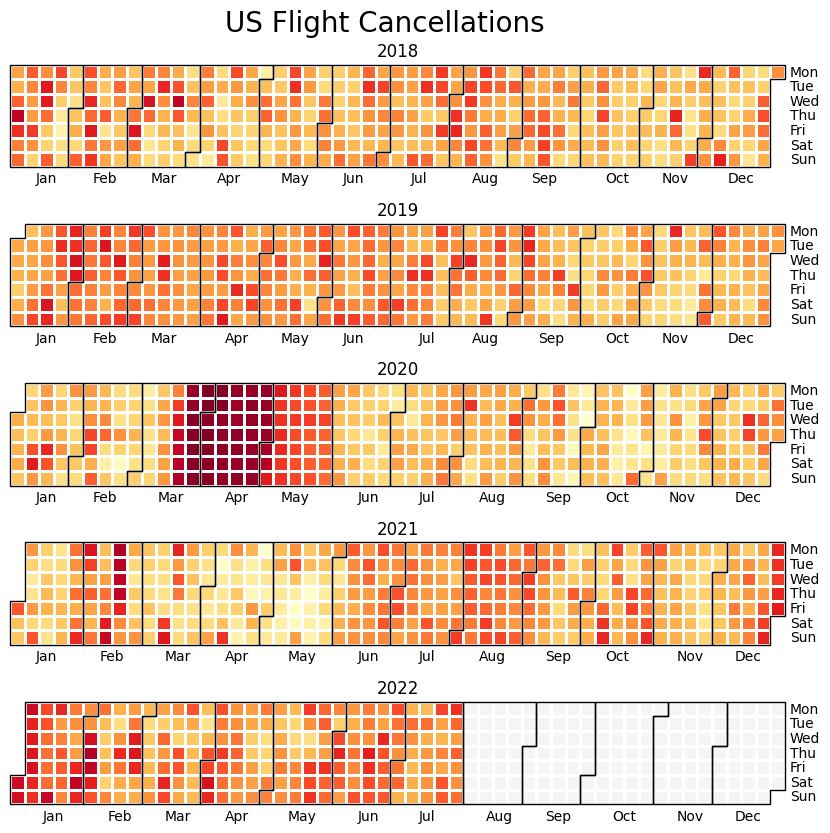

In [21]:
events = df.groupby("FlightDate")["Cancelled"].mean()

fig, axs = plt.subplots(5, 1,figsize=(10,10))
for i, year in enumerate([2018, 2019, 2020, 2021, 2022]):
    calmap.yearplot(events.apply(np.log), year=year, cmap='YlOrRd', monthly_border=True, ax=axs[i])
    axs[i].set_title(year)
fig.suptitle("US Flight Cancellations", y=0.92, fontsize=20)
plt.show()

## Make it interactive

In [22]:
# from plotly_calplot import calplot

# # creating the plot
# fig = calplot(events.apply(np.log).reset_index(), x="FlightDate", y="Cancelled")
# fig.show()

# Compare Airlines
- Who has the most delays?
- Who has the most cancelations?
- Who is the most on time?

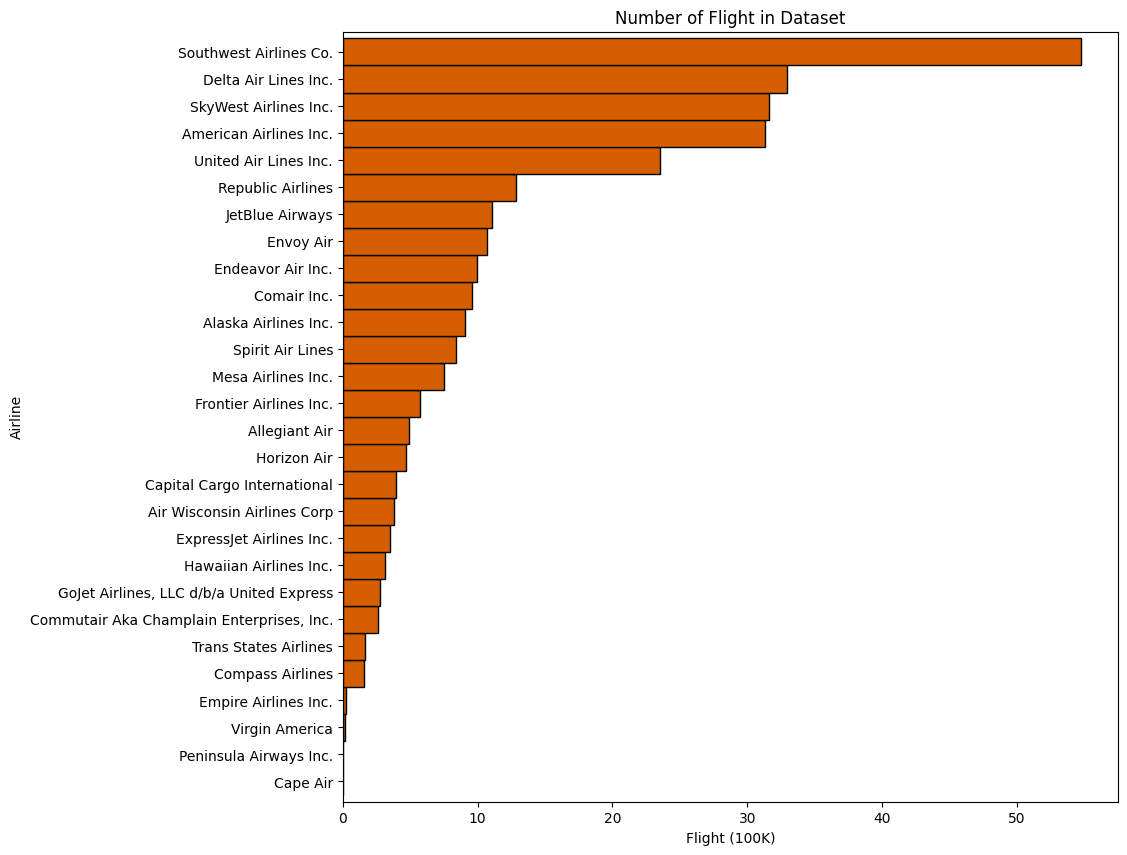

In [23]:
plt.figure(figsize=(10,10))
(df['Airline'].value_counts(ascending=True)/100000).plot(kind='barh', color=pal[2], width=1, edgecolor='black')
plt.title('Number of Flight in Dataset')
plt.xlabel('Flight (100K)')
plt.show()

## Subset the top Airlines
- Minimum 2M Flights

In [24]:
top_airlines = df['Airline'].value_counts().reset_index().query('count > 1_000_000')['Airline'].values.tolist()
df_top = df.loc[df["Airline"].isin(top_airlines)].reset_index(drop=True).copy()

In [25]:
df_top["Airline"] = df_top["Airline"].astype("str").astype("category")

/tmp/ipykernel_18/4269093190.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df_top.groupby(["Airline"]) \


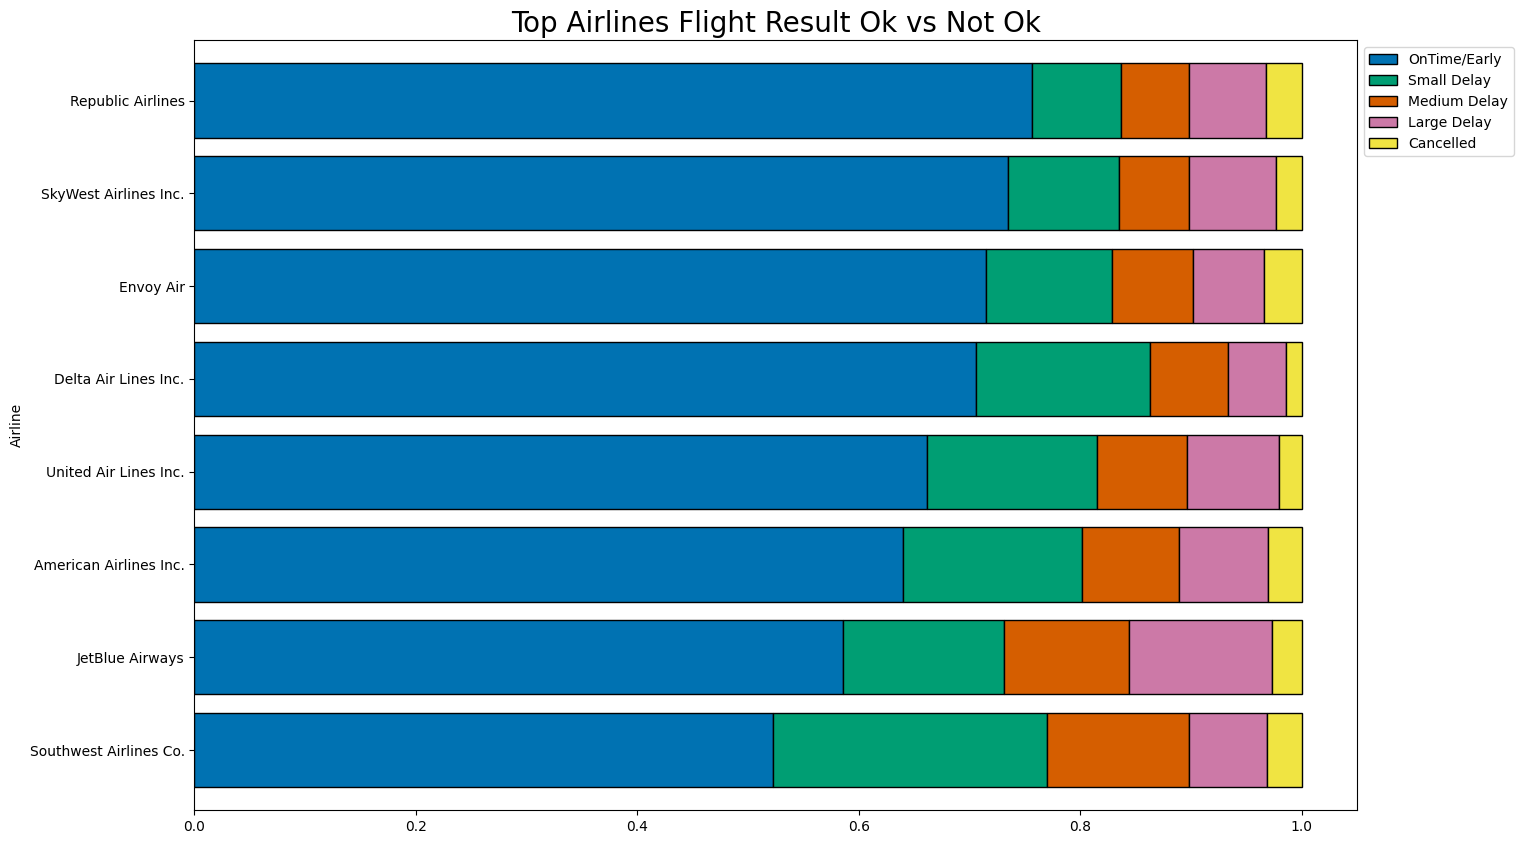

In [26]:
col_order = ["OnTime/Early", "Small Delay", "Medium Delay", "Large Delay", "Cancelled"]
df_agg = df_top.groupby(["Airline"]) \
        ["DelayGroup"].value_counts(normalize=True) \
        .unstack()[col_order]

fig, ax = plt.subplots(figsize=(15, 10))

df_agg.sort_values('OnTime/Early').plot(kind='barh', stacked=True, ax=ax, width=0.8, edgecolor='black')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title("Top Airlines Flight Result Ok vs Not Ok", fontsize=20)

plt.show()

# Split out Each Delay Type and plot

In [27]:
delay_mapping = {
    "OnTime/Early": "Good",
    "Small Delay": "Good",
    "Medium Delay": "Bad",
    "Large Delay": "Bad",
    "Cancelled": "Bad",
}

In [28]:
df_top["DelayOk"] = df_top["DelayGroup"].map(delay_mapping)

/tmp/ipykernel_18/635020729.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_top.groupby(["Airline"])["DelayOk"]


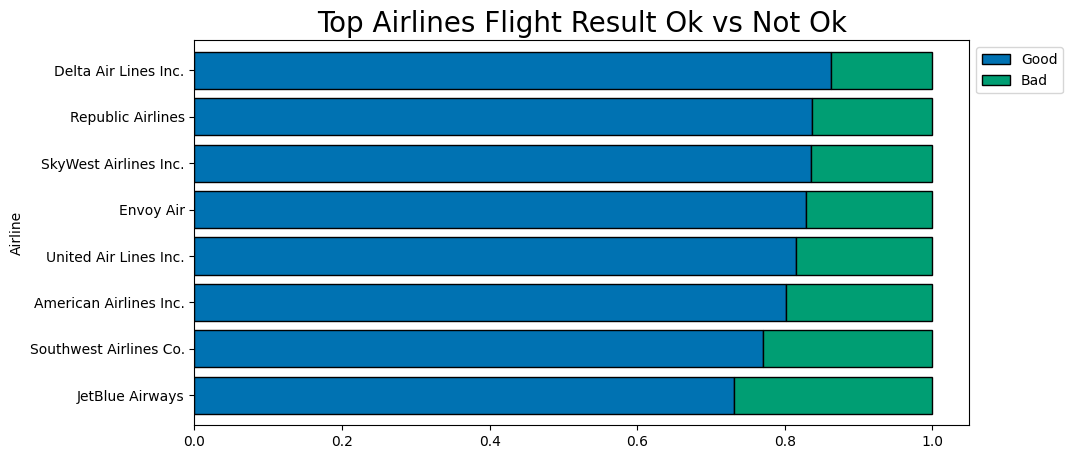

In [29]:
df_agg = (
    df_top.groupby(["Airline"])["DelayOk"]
    .value_counts(normalize=True)
    .unstack()[["Good", "Bad"]]
)

fig, ax = plt.subplots(figsize=(10, 5))
df_agg.sort_values("Good").plot(
    kind="barh", stacked=True, ax=ax, width=0.8, edgecolor="black"
)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title("Top Airlines Flight Result Ok vs Not Ok", fontsize=20)

plt.show()